# Online support vector classification with kernels
Each new datapoint may enter or leave the *support vector set*. That makes the QP evolve over time.


### Problem setup

We consider binary classification with data arriving sequentially:

* At round $t$, receive $(x_t, y_t)$, with $x_t \in \mathbb{R}^d$, $y_t \in \{-1,1\}$.
* Maintain a kernel SVM model with active support vectors $S_t$.
* Solve the dual SVM problem on $S_t$:

$$
\begin{aligned}
\max_{\alpha \in \mathbb{R}^{|S_t|}} \;& \sum_{i=1}^{|S_t|} \alpha_i - \tfrac{1}{2} \sum_{i,j=1}^{|S_t|} \alpha_i \alpha_j y_i y_j K(x_i, x_j) \\
\text{s.t. } & 0 \le \alpha_i \le C,\;\; \sum_{i=1}^{|S_t|} \alpha_i y_i = 0.
\end{aligned}
$$

This is a **quadratic program** with:

* Quadratic objective in $\alpha$.
* Linear equality constraint (label balance).
* Box constraints on $\alpha$.

As new points arrive:

* If the margin condition is violated, add $x_t$ to $S_t$.
* If budget exceeded, remove a support vector (budgeted SVM).
  Thus the dimension of the QP and the constraint set change online.

### Key properties for us

* Each new data point can change the set of decision variables ($\alpha$) and constraints.
* The QP has the same structure but varying size.
* Real-time requirement: in practice, online kernel SVMs need fast repeated QP solves.

t=0, support size=1, alphas=[6.28716735e-07]
[0]


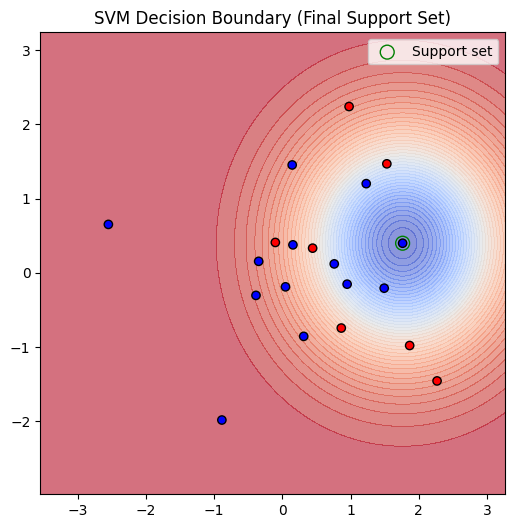

t=1, support size=2, alphas=[1. 1.]
[0, 1]


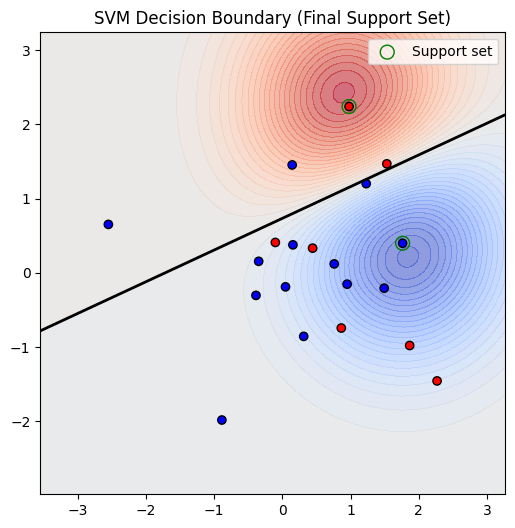

t=2, support size=3, alphas=[1.        0.3744262 0.6255738]
[0, 1, 2]


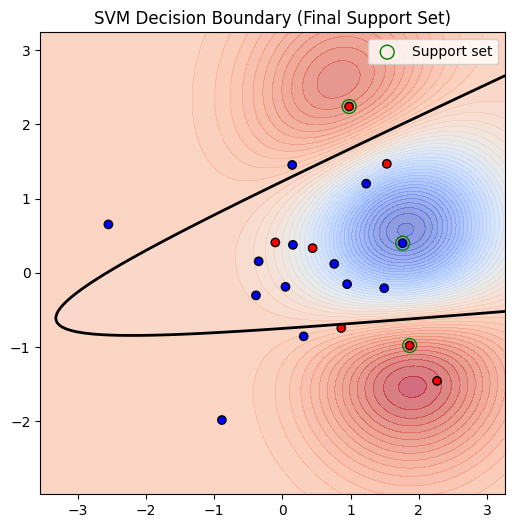

t=3, support size=4, alphas=[1.00000001 1.         1.         0.99999999]
[0, 1, 2, 3]


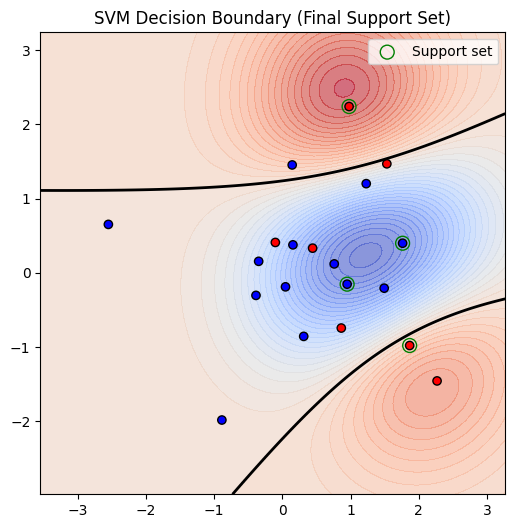

t=4, support size=5, alphas=[1.         0.27590118 0.97545821 1.         0.74864061]
[0, 1, 2, 3, 4]


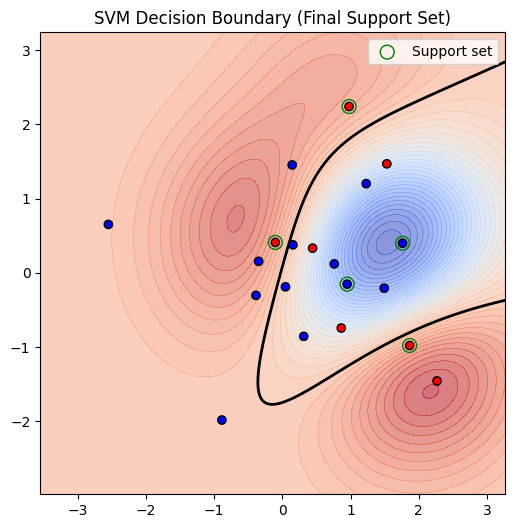

t=5, support size=6, alphas=[1. 1. 1. 1. 1. 1.]
[0, 1, 2, 3, 4, 5]


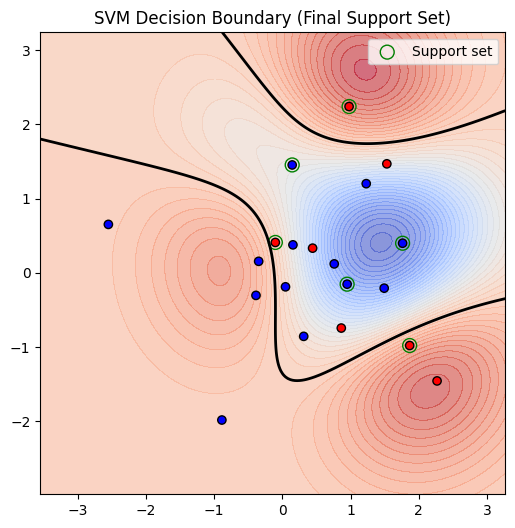

t=6, support size=7, alphas=[0.67986913 1.         1.         1.         1.         1.
 0.32013087]
[0, 1, 2, 3, 4, 5, 6]


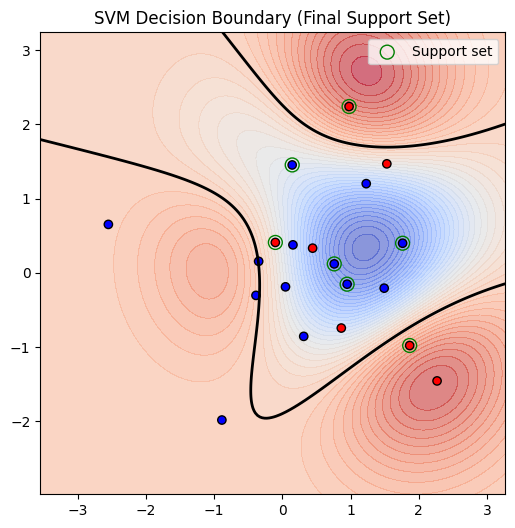

t=7, support size=8, alphas=[1. 1. 1. 1. 1. 1. 1. 1.]
[0, 1, 2, 3, 4, 5, 6, 7]


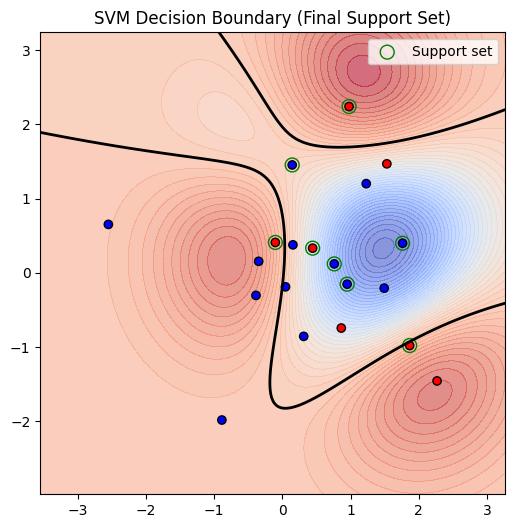

t=8, support size=9, alphas=[0.45305211 1.         1.         1.         1.         1.
 1.         1.         0.54694789]
[0, 1, 2, 3, 4, 5, 6, 7, 8]


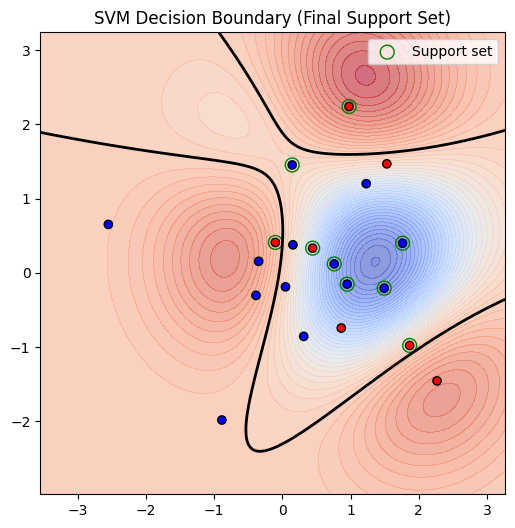

t=9, support size=10, alphas=[ 4.48427600e-01  1.00000000e+00  1.00000000e+00 -1.41010239e-23
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  5.88276917e-01  9.63295483e-01]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


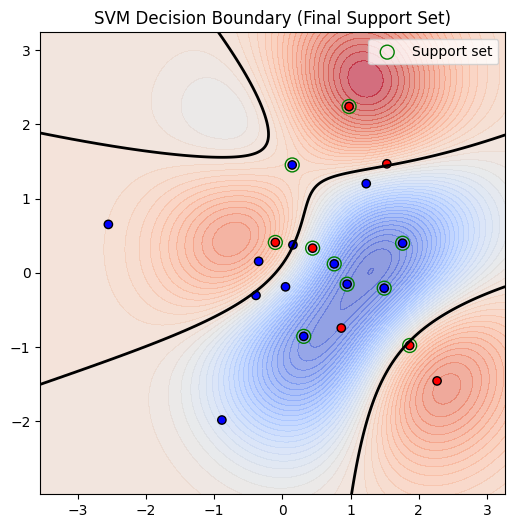

t=10, support size=10, alphas=[0.18741229 1.         1.         1.         1.         1.
 1.         0.62969446 0.719087   0.46380625]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10]


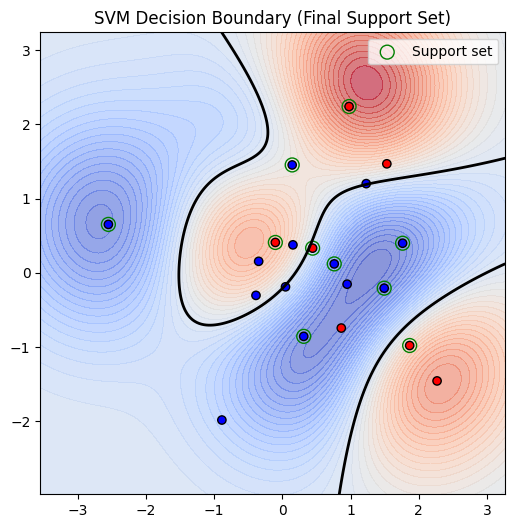

t=11, support size=10, alphas=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1, 2, 4, 5, 6, 7, 8, 9, 10, 11]


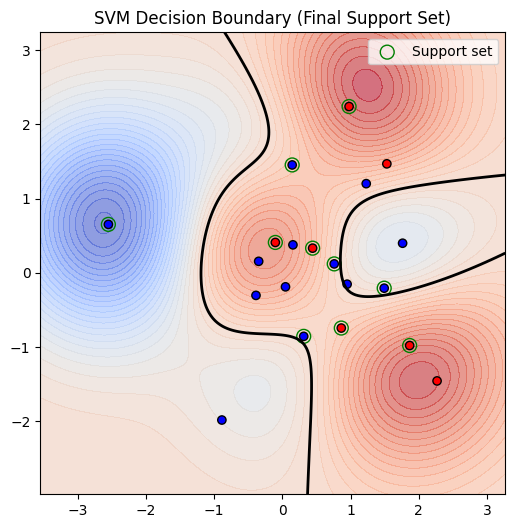

t=12, support size=10, alphas=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1, 2, 4, 5, 6, 7, 8, 9, 10, 11]


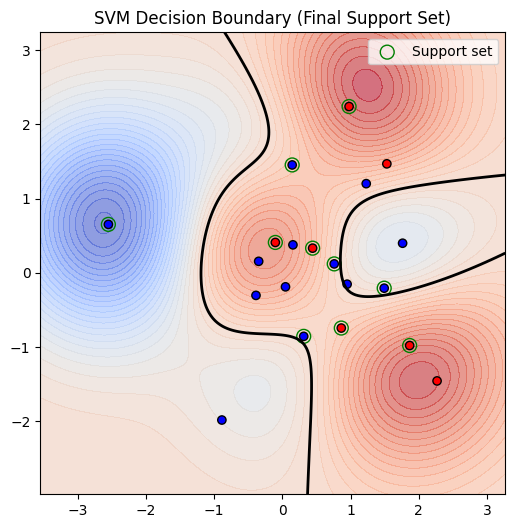

t=13, support size=10, alphas=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1, 2, 4, 5, 6, 7, 8, 9, 11, 13]


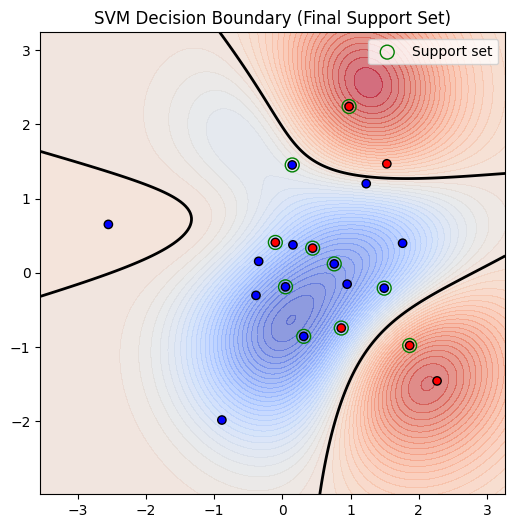

t=14, support size=10, alphas=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[2, 4, 5, 6, 7, 8, 9, 11, 13, 14]


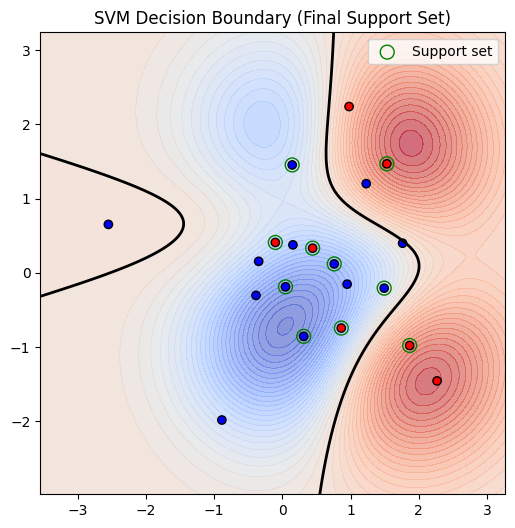

t=15, support size=10, alphas=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[2, 4, 5, 6, 7, 8, 9, 11, 14, 15]


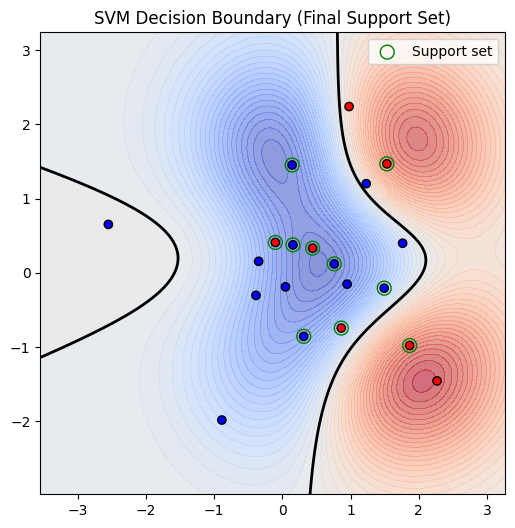

t=16, support size=10, alphas=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[2, 4, 5, 6, 7, 8, 9, 11, 14, 15]


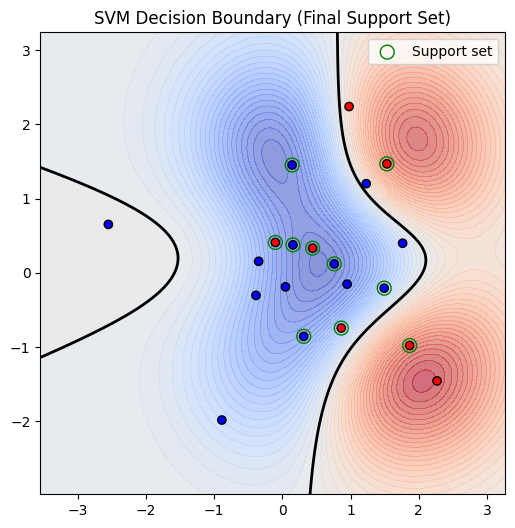

t=17, support size=10, alphas=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[2, 4, 5, 6, 7, 8, 9, 11, 14, 17]


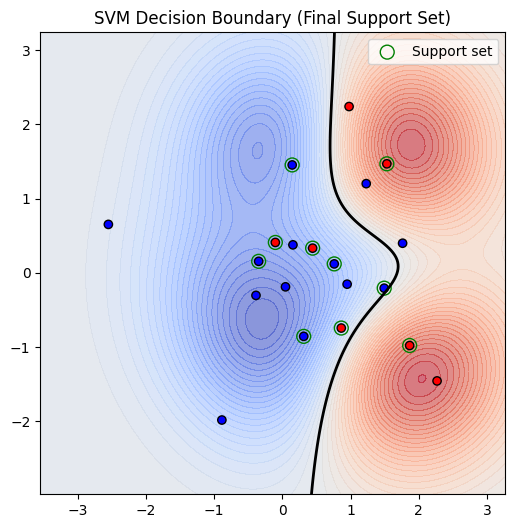

t=18, support size=10, alphas=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[2, 4, 6, 7, 8, 9, 11, 14, 17, 18]


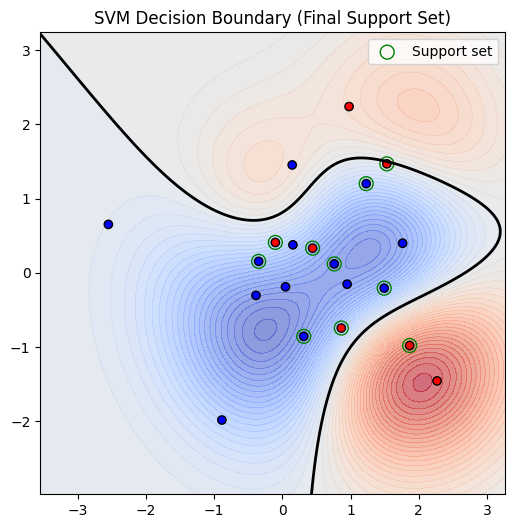

t=19, support size=10, alphas=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[2, 4, 6, 7, 8, 9, 11, 14, 17, 18]


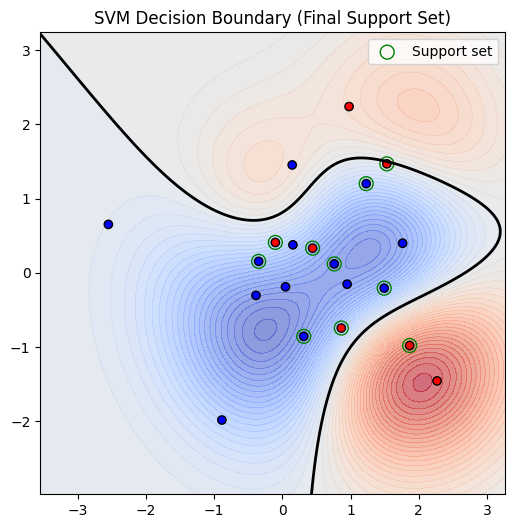

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Gaussian kernel
def rbf_kernel(X, Y=None, gamma=1.0):
    if Y is None:
        Y = X
    X_norm = np.sum(X**2, axis=1)[:, None]
    Y_norm = np.sum(Y**2, axis=1)[None, :]
    K = np.exp(-gamma * (X_norm + Y_norm - 2 * X @ Y.T))
    return K

def solve_svm_dual(X, y, C=1.0, gamma=1.0):
    n = X.shape[0]
    K = rbf_kernel(X, gamma=gamma)
    # QP variables
    alpha = cp.Variable(n)
    # Dual objective
    obj = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(cp.multiply(y, alpha), K))
    # Constraints
    constraints = [alpha >= 0, alpha <= C, cp.sum(cp.multiply(alpha, y)) == 0]
    prob = cp.Problem(obj, constraints)
    prob.solve(solver="OSQP", verbose=False)
    return alpha.value

# Decision function
def decision_function(X_test, Xs, ys, alpha, gamma):
    K = rbf_kernel(X_test, Xs, gamma=gamma)
    return (alpha * ys) @ K.T
# Simulated online process
np.random.seed(0)
X = np.random.randn(20, 2)
y = np.random.choice([-1, 1], size=20)

# Grid for plotting
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200),
                    np.linspace(X[:,1].min()-1, X[:,1].max()+1, 200))
X_grid = np.c_[xx.ravel(), yy.ravel()]

support_set = []
budget = 10
C = 1.0
gamma = 0.5

for t in range(len(y)):
    support_set.append(t)
    if len(support_set) > budget:
    #     # Simple budget policy: drop oldest
    #     support_set.pop(0)
        # Remove the one least contributing to the margin
        alphas = solve_svm_dual(X[support_set], y[support_set], C=C, gamma=gamma)
        min_alpha_idx = np.argmin(alphas)
        support_set.pop(min_alpha_idx)
    Xs, ys = X[support_set], y[support_set]
    #print(Xs)
    alpha = solve_svm_dual(Xs, ys, C=C, gamma=gamma)
    print(f"t={t}, support size={len(support_set)}, alphas={alpha}") #[:3]
    print(support_set)

    Z = decision_function(X_grid, Xs, ys, alpha, gamma).reshape(xx.shape)

    # Plot
    plt.figure(figsize=(6,6))
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="k")   # decision boundary
    # plt.contour(xx, yy, Z, levels=[-0.1, 0.1], linestyles="--", colors="k")  # margins
    # plt.contour(xx, yy, Z, levels=[-0.3, 0.3], linestyles="--", colors="k")  # margins
    # plt.contour(xx, yy, Z, levels=[-0.5, 0.5], linestyles="--", colors="k")  # margins
    # plt.contour(xx, yy, Z, levels=[-0.7, 0.7], linestyles="--", colors="k")  # margins
    plt.contourf(xx, yy, Z, levels=50, cmap="coolwarm", alpha=0.6)
    plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr, edgecolors="k")
    plt.scatter(Xs[:,0], Xs[:,1], s=100, facecolors="none", edgecolors="g", label="Support set")
    plt.legend()
    plt.title("SVM Decision Boundary (Final Support Set)")
    plt.show()

[[ 1.86755799 -0.97727788]
 [-0.10321885  0.4105985 ]
 [ 0.76103773  0.12167502]
 [ 0.44386323  0.33367433]
 [ 1.49407907 -0.20515826]
 [ 0.3130677  -0.85409574]
 [ 0.8644362  -0.74216502]
 [ 1.53277921  1.46935877]
 [-0.34791215  0.15634897]
 [ 1.23029068  1.20237985]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


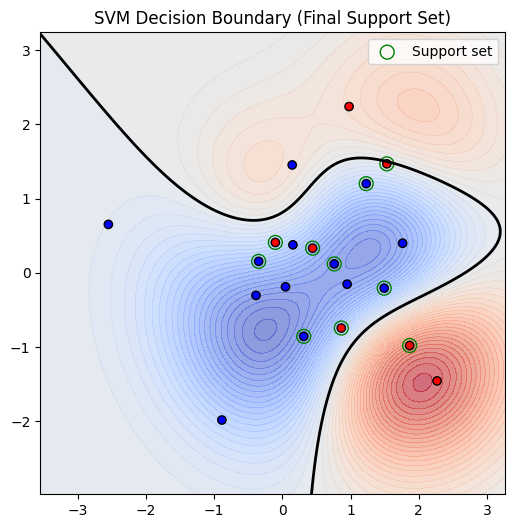

In [2]:
import matplotlib.pyplot as plt


# Decision function
def decision_function(X_test, Xs, ys, alpha, gamma):
    K = rbf_kernel(X_test, Xs, gamma=gamma)
    return (alpha * ys) @ K.T

# Grid for plotting
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200),
                     np.linspace(X[:,1].min()-1, X[:,1].max()+1, 200))
X_grid = np.c_[xx.ravel(), yy.ravel()]
Z = decision_function(X_grid, Xs, ys, alpha, gamma).reshape(xx.shape)

print(Xs)
print(alpha)
# Plot
plt.figure(figsize=(6,6))
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="k")   # decision boundary
# plt.contour(xx, yy, Z, levels=[-0.1, 0.1], linestyles="--", colors="k")  # margins
# plt.contour(xx, yy, Z, levels=[-0.3, 0.3], linestyles="--", colors="k")  # margins
# plt.contour(xx, yy, Z, levels=[-0.5, 0.5], linestyles="--", colors="k")  # margins
# plt.contour(xx, yy, Z, levels=[-0.7, 0.7], linestyles="--", colors="k")  # margins
plt.contourf(xx, yy, Z, levels=50, cmap="coolwarm", alpha=0.6)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr, edgecolors="k")
plt.scatter(Xs[:,0], Xs[:,1], s=100, facecolors="none", edgecolors="g", label="Support set")
plt.legend()
plt.title("SVM Decision Boundary (Final Support Set)")
plt.show()

3
0
10
8
0
8
10
9
2
10
[[ 1.86755799 -0.97727788]
 [-0.10321885  0.4105985 ]
 [ 0.76103773  0.12167502]
 [ 0.44386323  0.33367433]
 [ 1.49407907 -0.20515826]
 [ 0.3130677  -0.85409574]
 [ 0.8644362  -0.74216502]
 [ 1.53277921  1.46935877]
 [-0.34791215  0.15634897]
 [ 1.23029068  1.20237985]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


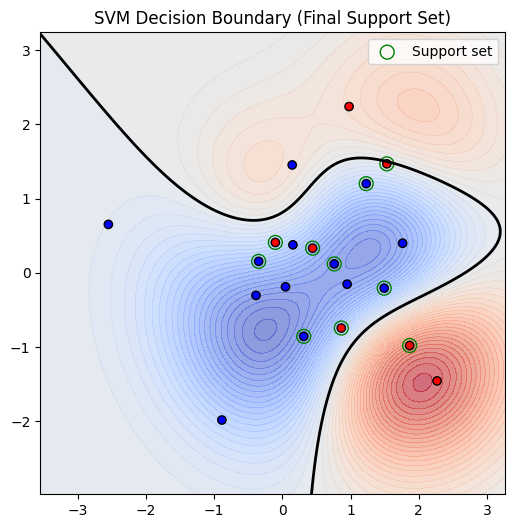

[[ 1.86755799 -0.97727788]
 [-0.10321885  0.4105985 ]
 [ 0.76103773  0.12167502]
 [ 0.44386323  0.33367433]
 [ 1.49407907 -0.20515826]
 [ 0.3130677  -0.85409574]
 [ 0.8644362  -0.74216502]
 [ 1.53277921  1.46935877]
 [-0.34791215  0.15634897]
 [ 1.23029068  1.20237985]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


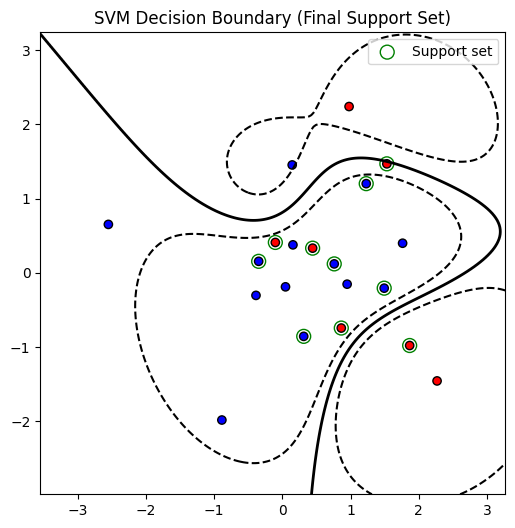

In [3]:
import matplotlib.pyplot as plt
# Simulated online process
np.random.seed(0)
X = np.random.randn(20, 2)
y = np.random.choice([-1, 1], size=20)

support_set = []
budget = 10
C = 1.0
gamma = 0.5

for t in range(len(y)):
    support_set.append(t)
    if len(support_set) > budget:
        # Simple budget policy: drop oldest
        # support_set.pop(0)
        # Remove the one least contributing to the margin
        alphas = solve_svm_dual(X[support_set], y[support_set], C=C, gamma=gamma)
        min_alpha_idx = np.argmin(alphas)
        print(min_alpha_idx)
        support_set.pop(min_alpha_idx)

    Xs, ys = X[support_set], y[support_set]
    #print(Xs)
    alpha = solve_svm_dual(Xs, ys, C=C, gamma=gamma)
    #print(f"t={t}, support size={len(support_set)}, alphas={alpha}") #[:3]
    # Grid for plotting
    xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200),
                        np.linspace(X[:,1].min()-1, X[:,1].max()+1, 200))
    X_grid = np.c_[xx.ravel(), yy.ravel()]
    Z = decision_function(X_grid, Xs, ys, alpha, gamma).reshape(xx.shape)

print(Xs)
print(alpha)
# Plot
plt.figure(figsize=(6,6))
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="k")   # decision boundary
# plt.contour(xx, yy, Z, levels=[-0.1, 0.1], linestyles="--", colors="k")  # margins
# plt.contour(xx, yy, Z, levels=[-0.3, 0.3], linestyles="--", colors="k")  # margins
# plt.contour(xx, yy, Z, levels=[-0.5, 0.5], linestyles="--", colors="k")  # margins
# plt.contour(xx, yy, Z, levels=[-0.7, 0.7], linestyles="--", colors="k")  # margins
plt.contourf(xx, yy, Z, levels=50, cmap="coolwarm", alpha=0.6)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr, edgecolors="k")
plt.scatter(Xs[:,0], Xs[:,1], s=100, facecolors="none", edgecolors="g", label="Support set")
plt.legend()
plt.title("SVM Decision Boundary (Final Support Set)")
plt.show()

print(Xs)
print(alpha)
# Plot
plt.figure(figsize=(6,6))
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="k")   # decision boundary
plt.contour(xx, yy, Z, levels=[-0.1, 0.1], linestyles="--", colors="k")  # margins
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr, edgecolors="k")
plt.scatter(Xs[:,0], Xs[:,1], s=100, facecolors="none", edgecolors="g", label="Support set")
plt.legend()
plt.title("SVM Decision Boundary (Final Support Set)")
plt.show()

In [4]:
## model QP here as graph

# one node per variable
# one node per constraint
# how to handle equality constraints? - geq and leq

# 1/2 x^TQx + c^Tx
# s.t. Ax <= b

# define objective
# obj = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(cp.multiply(y, alpha), K))
# ==  obj = cp.Minimize(-cp.sum(alpha) + 0.5 * cp.quad_form(cp.multiply(y, alpha), K))

# Q = cp.quad_form(cp.multiply(y, alpha), K) => Q = K * (y y^T) (elementwise multiplication)
# x = alpha
# c^Tx = - cp.sum(alpha) => c = [-1,....,-1] (for all alphas that are in S_t, otherwise 0)


# define constraints
# constraints = [alpha >= 0, alpha <= C, cp.sum(cp.multiply(alpha, y)) == 0]

# -alpha <= 0
# alpha <= C
# y^T alpha = 0 => y^T alpha <= 0 and -y^T alpha <= 0

# X and y given, Xs,ys given (X[support_set], y[support_set])
# define variables for QP
K = rbf_kernel(Xs, gamma=gamma)
H = np.transpose(ys)*K * ys
f = np.ones(len(support_set)) * -1    #np.where(np.array([i in support_set for i in range(len(y))]), -1, 0)

A = np.vstack((-np.eye(len(support_set)), np.eye(len(support_set)))) #, ys, -ys))       # no equality constraints enforced
b = np.hstack((np.zeros(len(support_set)), C*np.ones(len(support_set)))) #, 0, 0))

print(K.shape,H.shape,f.shape,A.shape,b.shape)

# Q changes in each iteration, whenever the support set changes





(10, 10) (10, 10) (10,) (20, 10) (20,)


In [5]:
# solve DAQP
import daqp
import numpy as np

print("condition number of H",np.linalg.cond(H))

n = H.shape[0]
m = b.shape[0]

sense = np.zeros(m, dtype=np.int32)
blower = np.array([-np.inf for i in range(m)])

lambda_daqp = np.zeros((1,m))


_,_,_,info = daqp.solve(H,f,A,b,blower,sense)
print("lambda",list(info.values())[4],"iterations",list(info.values())[2],"time",list(info.values())[0])
lambda_daqp = list(info.values())[4]

iterations_daqp = list(info.values())[2]
time_daqp = list(info.values())[0]

condition number of H 2524.2373191658003
lambda [0.         0.00731716 0.11146733 0.08688763 0.06035752 0.
 0.09777095 0.         0.         0.03848231 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ] iterations 7 time 5.8e-06


In [6]:
# generate graph data
import torch
from torch_geometric.data import Data


# get optimal active set (y)
train_active_set = (lambda_daqp != 0).astype(int)
print(train_active_set)
print(train_active_set.shape, np.zeros((iterations_daqp,n)).shape)
y_train = torch.tensor((np.hstack((np.zeros((n)),train_active_set)))) 

# graph structure does not change, only vertex features
#combine H and A
edge_matrix = np.block([[H,A.T],[A,np.zeros((np.shape(A)[0],np.shape(A)[0]))]])

# create edge_index and edge_attributes
edge_index = torch.tensor([])
edge_attr = torch.tensor([])
for j in range(np.shape(edge_matrix)[0]):
    for k in range(np.shape(edge_matrix)[1]):
        # add edge
        if edge_matrix[j,k] != 0:
            edge_index = torch.cat((edge_index,torch.tensor([[j,k]])),0)
            edge_attr = torch.cat((edge_attr,torch.tensor([edge_matrix[j,k]])),0)
edge_index = edge_index.long().T

# create new vectors filled with zeros to capture vertex features better
f1_train = np.hstack((f,np.zeros(np.shape(b))))
b1_train = np.hstack((np.zeros(np.shape(f)),b))
eq1_train = np.hstack((np.zeros(np.shape(f)),(np.zeros(np.shape(b)))))
node_type_train = np.hstack((np.zeros(np.shape(f)),(np.ones(np.shape(b)))))

#print(f1_train.shape,b1_train.shape,eq1_train.shape)

features = np.array([f1_train, b1_train, eq1_train,node_type_train]).T
x_train = torch.tensor(features, dtype=torch.float32)
data_point = Data(x= x_train, edge_index=edge_index, edge_attr=edge_attr,y=y_train)
#print(data_point)
# list of graph elements
print(data_point)
# graph_train.append(data_point)

[0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0]
(20,) (7, 10)
Data(x=[30, 4], edge_index=[2, 140], edge_attr=[140], y=[30])


In [82]:
## whole process

# Simulated online process
np.random.seed(0)
X = np.random.randn(20, 2)
y = np.random.choice([-1, 1], size=20)

support_set = []
budget = 20
C = 1.0
gamma = 0.5

# Generate the graph from the training data
graph_train = []

for t in range(len(y)):
    support_set.append(t)
    if len(support_set) > budget:
        # Simple budget policy: drop oldest
        #support_set.pop(0)
        # Remove the one least contributing to the margin
        alphas = solve_svm_dual(X[support_set], y[support_set], C=C, gamma=gamma)
        min_alpha_idx = np.argmin(alphas)
        support_set.pop(min_alpha_idx)
    Xs, ys = X[support_set], y[support_set]

    alpha = solve_svm_dual(Xs, ys, C=C, gamma=gamma)
    print(f"t={t}, support size={len(support_set)}, alphas={alpha}")
    print(support_set)
    
    # optimal labels for current support set
    y_train = np.where(np.array([i in support_set for i in range(t)]), 1, 0)
    print("labels", y_train)

    K = rbf_kernel(Xs, gamma=gamma)
    H = np.transpose(ys)*K * ys
    f = np.ones(len(support_set)) * -1    #np.where(np.array([i in support_set for i in range(len(y))]), -1, 0)

    A = np.vstack((-np.eye(len(support_set)), np.eye(len(support_set))))# , ys, -ys))
    b = np.hstack((np.zeros(len(support_set)), C*np.ones(len(support_set)))) #, 0, 0))

    print(H.shape,b.shape,f.shape,A.shape,b.shape)
    # graph structure does not change, only vertex features
    #combine H and A
    edge_matrix = np.block([[H,A.T],[A,np.zeros((np.shape(A)[0],np.shape(A)[0]))]])

    # create edge_index and edge_attributes
    edge_index = torch.tensor([])
    edge_attr = torch.tensor([])
    for j in range(np.shape(edge_matrix)[0]):
        for k in range(np.shape(edge_matrix)[1]):
            # add edge
            if edge_matrix[j,k] != 0:
                edge_index = torch.cat((edge_index,torch.tensor([[j,k]])),0)
                edge_attr = torch.cat((edge_attr,torch.tensor([edge_matrix[j,k]])),0)
    edge_index = edge_index.long().T

    # create new vectors filled with zeros to capture vertex features better
    f1_train = np.hstack((f,np.zeros(np.shape(b))))
    b1_train = np.hstack((np.zeros(np.shape(f)),b))
    eq1_train = np.hstack((np.zeros(np.shape(f)),(np.zeros(np.shape(b)))))
    node_type_train = np.hstack((np.zeros(np.shape(f)),(np.ones(np.shape(b)))))

    #print(f1_train.shape,b1_train.shape,eq1_train.shape)

    features = np.array([f1_train, b1_train, eq1_train,node_type_train]).T
    x_train = torch.tensor(features, dtype=torch.float32)
    data_point = Data(x= x_train, edge_index=edge_index, edge_attr=edge_attr,y=y_train)
    #print(data_point)
    # list of graph elements
    #print(data_point)
    # graph_train.append(data_point)
    print(data_point)
    graph_train.append(data_point)
print(len(graph_train))

t=0, support size=1, alphas=[6.28716735e-07]
[0]
labels []
(1, 1) (2,) (1,) (2, 1) (2,)
Data(x=[3, 4], edge_index=[2, 5], edge_attr=[5], y=[0])
t=1, support size=2, alphas=[1. 1.]
[0, 1]
labels [1]
(2, 2) (4,) (2,) (4, 2) (4,)
Data(x=[6, 4], edge_index=[2, 12], edge_attr=[12], y=[1])
t=2, support size=3, alphas=[1.        0.3744262 0.6255738]
[0, 1, 2]
labels [1 1]
(3, 3) (6,) (3,) (6, 3) (6,)
Data(x=[9, 4], edge_index=[2, 21], edge_attr=[21], y=[2])
t=3, support size=4, alphas=[1.00000001 1.         1.         0.99999999]
[0, 1, 2, 3]
labels [1 1 1]
(4, 4) (8,) (4,) (8, 4) (8,)
Data(x=[12, 4], edge_index=[2, 32], edge_attr=[32], y=[3])
t=4, support size=5, alphas=[1.         0.27590118 0.97545821 1.         0.74864061]
[0, 1, 2, 3, 4]
labels [1 1 1 1]
(5, 5) (10,) (5,) (10, 5) (10,)
Data(x=[15, 4], edge_index=[2, 45], edge_attr=[45], y=[4])
t=5, support size=6, alphas=[1. 1. 1. 1. 1. 1.]
[0, 1, 2, 3, 4, 5]
labels [1 1 1 1 1]
(6, 6) (12,) (6,) (12, 6) (12,)
Data(x=[18, 4], edge_index=[

In [ ]:
## predict support vectors using GNN

# training dataset - data in each online step
# label - if a point is in the support set or not

# generate all data first, act as "time series" and split it test, val, train later
def generate_qp_graphs_svm(seed,number_of_graphs):
    # Simulated online process
    np.random.seed(seed)
    X = np.random.randn(number_of_graphs, 2)
    y = np.random.choice([-1, 1], size=number_of_graphs)
    #np.savez(f"data/generated_qp_data_{n}v_{m}c_lmpc.npz", H=H, f=f, F=F, A=A, b=b, B=B)

    support_set = []
    budget = 20
    C = 1.0
    gamma = 0.5
    
    # Generate the graph from the data
    graphs = []
    sum_Hb = 0
    for t in range(len(y)): 
        support_set.append(t)
        if len(support_set) > budget:
            # Simple budget policy: drop oldest
            #support_set.pop(0)
            # Remove the one least contributing to the margin
            alphas = solve_svm_dual(X[support_set], y[support_set], C=C, gamma=gamma)
            min_alpha_idx = np.argmin(alphas)
            support_set.pop(min_alpha_idx)
        Xs, ys = X[support_set], y[support_set]

        alpha = solve_svm_dual(Xs, ys, C=C, gamma=gamma)
        # print(f"t={t}, support size={len(support_set)}, alphas={alpha}") #[:3]
        # print(support_set)
        # print(support_set)
        # optimal labels for current support set
        #y_train1 = torch.tensor(((np.zeros((Xs.shape[0])*3)))) #,np.where(np.array([i in support_set for i in range(len(ys))]), 1, 0),np.where(np.array([i in support_set for i in range(len(ys))]), 1, 0)))))      #### HERE HERE HERE        # 
        y_train = torch.tensor(((np.hstack((np.zeros((Xs.shape[0])),np.where(np.array([i in support_set for i in range(len(ys))]), 1, 0),np.where(np.array([i in support_set for i in range(len(ys))]), 1, 0))))))
        # only constraints: 88 are missing
        # print("Xs*3",y_train1.shape)
        # print("labels", y_train.shape)
        # print("length y_train", np.where(np.array([i in support_set for i in range(len(y))]), 1, 0).shape)
        # print("length Xs", Xs.shape)
        # print("length ys", ys.shape)
        # print(y_train)
        K = rbf_kernel(Xs, gamma=gamma)
        H = np.transpose(ys)*K * ys
        f = np.ones(len(support_set)) * -1    #np.where(np.array([i in support_set for i in range(len(y))]), -1, 0)
        A = np.vstack((-np.eye(len(support_set)), np.eye(len(support_set))))# , ys, -ys))
        b = np.hstack((np.zeros(len(support_set)), C*np.ones(len(support_set)))) #, 0, 0))
        #print(H.shape,f.shape,A.shape,b.shape)

        # print(y_train.shape)
        # print(Xs.shape)
        # print(H.shape)
        # print(b.shape)
        #print("H+b",H.shape[0]+b.shape[0])

        # graph structure does not change, only vertex features
        #combine H and A
        edge_matrix = np.block([[H,A.T],[A,np.zeros((np.shape(A)[0],np.shape(A)[0]))]])
        
        # create edge_index and edge_attributes
        edge_index = torch.tensor([])
        edge_attr = torch.tensor([])
        for j in range(np.shape(edge_matrix)[0]):
            for k in range(np.shape(edge_matrix)[1]):
                # add edge
                if edge_matrix[j,k] != 0:
                    edge_index = torch.cat((edge_index,torch.tensor([[j,k]])),0)
                    edge_attr = torch.cat((edge_attr,torch.tensor([edge_matrix[j,k]])),0)
        edge_index = edge_index.long().T
        
        # create new vectors filled with zeros to capture vertex features better
        f1_train = np.hstack((f,np.zeros(np.shape(b))))
        b1_train = np.hstack((np.zeros(np.shape(f)),b))
        eq1_train = np.hstack((np.zeros(np.shape(f)),(np.zeros(np.shape(b)))))
        node_type_train = np.hstack((np.zeros(np.shape(f)),(np.ones(np.shape(b)))))

        #print(f1_train.shape,b1_train.shape,eq1_train.shape)

        features = np.array([f1_train, b1_train, eq1_train,node_type_train]).T
        x_train = torch.tensor(features, dtype=torch.float32)
        # print(y_train)
        data_point = Data(x= x_train, edge_index=edge_index, edge_attr=edge_attr,y=y_train)
        #print(data_point)
        # list of graph elements
        graphs.append(data_point)

    return graphs


In [137]:

seed = 0
number_of_graphs = 500
graphs = generate_qp_graphs_svm(seed,number_of_graphs)



0


In [138]:
# experiment on GNN
print(0.8*number_of_graphs)
graph_train = graphs[:int(0.8*number_of_graphs)]
graph_val = graphs[int(0.8*number_of_graphs):int(0.9*number_of_graphs)]
graph_test = graphs[int(0.9*number_of_graphs):]


400.0


In [139]:
import numpy as np
from ctypes import * 
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score

import torch
from torch_geometric.loader import DataLoader as GraphDataLoader

from model import GNN
from model import EarlyStopping

layer_width = 128
conv_type = "LEConv"
number_of_max_epochs = 100
number_of_layers = 3
t = 0.9

# Load Data
train_batch_size = 64
train_loader = GraphDataLoader(graph_train, batch_size=train_batch_size, shuffle=False)
val_loader = GraphDataLoader(graph_val,batch_size = len(graph_val), shuffle = False)

# Compute class weights for imbalanced classes
all_labels = np.concat([data.y for data in graph_train])
# class_weights = compute_class_weight('balanced', classes=torch.unique(all_labels).numpy(), y=all_labels.numpy())
# class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Instantiate model and optimizer
model = GNN(input_dim=4, output_dim=1,layer_width = layer_width,conv_type = conv_type)  # Output dimension 1 for binary classification
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)

# Early stopping
early_stopping = EarlyStopping(patience=5, delta=0.001)


# Training
for epoch in range(number_of_max_epochs):
    # print(f"Epoch {epoch}")
    train_loss = 0
    train_all_labels = []
    train_preds = []
    model.train()
    output_train = []
    train_all_label_graph = []
    train_preds_graph = []
    
    for batch in train_loader:
        optimizer.zero_grad()
        output = model(batch,number_of_layers,conv_type)
        # print(output.shape)
        # print(output)
        output_train.extend(output.squeeze().detach().numpy().reshape(-1))
        # print(batch.y.shape)
        
        loss = torch.nn.BCELoss()(output.squeeze(), batch.y.float()) #weight=class_weights[batch.y.long()]
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Convert output to binary prediction (0 or 1)
        preds = (output.squeeze() > t).long()

        # Store predictions and true labels
        train_preds.extend(preds.numpy())   
        train_all_labels.extend(batch.y.numpy())
        

        # print("true labels",batch.y.shape, torch.nonzero(batch.y).squeeze().detach().numpy())
        # print("preds",preds.shape, torch.nonzero(preds).squeeze().detach().numpy())
        # print("output",output.squeeze()[torch.nonzero(batch.y).squeeze().detach().numpy()].detach().numpy())
        # print("loss",loss.item())

        # Save per graph predictions and labels
        for i in range(batch.num_graphs):
            mask = batch.batch == i
            preds_graph = preds[mask].numpy()
            labels_graph = batch.y[mask].numpy()
            
            #print(np.sum(preds_graph),np.sum(labels_graph))

            train_preds_graph.append(preds_graph)
            train_all_label_graph.append(labels_graph)

        # Compute metrics
        train_loss /= len(train_loader)
        train_acc = accuracy_score(train_all_labels, train_preds)
        train_prec = precision_score(train_all_labels,train_preds)
        train_rec = recall_score(train_all_labels, train_preds)
        train_f1 = f1_score(train_all_labels,train_preds)

        # Validation step
        model.eval()
        val_loss = 0
        val_mean_wrongly_pred_nodes_per_graph = 0
        val_num_wrongly_pred_nodes_per_graph = 0
        val_all_labels = []
        val_preds = []
        output_val = []
        val_preds_graph = []
        val_all_label_graph = []
        
        with torch.no_grad():
            for batch in val_loader:
                output = model(batch,number_of_layers,conv_type)
                output_val.extend(output.squeeze().detach().numpy().reshape(-1))
                loss = torch.nn.BCELoss()(output.squeeze(), batch.y.float())
                val_loss += loss.item()
                preds = (output.squeeze() > t).long()

                # Store predictions and labels
                val_preds.extend(preds.numpy())
                val_all_labels.extend(batch.y.numpy())
                
                # Store per graph predictions and labels
                for i in range(batch.num_graphs):
                    mask = batch.batch == i
                    preds_graph = preds[mask].numpy()
                    labels_graph = batch.y[mask].numpy()

                    val_preds_graph.append(preds_graph)
                    val_all_label_graph.append(labels_graph)                
        
        # Compute metrics      
        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_all_labels, val_preds)
        val_prec = precision_score(val_all_labels,val_preds)
        val_rec = recall_score(val_all_labels, val_preds)
        val_f1 = f1_score(val_all_labels,val_preds)

         # Print metrics
    print("TRAINING")
    print(f"Accuracy (node level) of the final model: {train_acc}")
    print(f"Precision of the model on the test data: {train_prec}")
    print(f"Recall of the model on the test data: {train_rec}")
    print(f"F1-Score of the model on the test data: {train_f1}")

    print("VALIDATION")
    print(f"Accuracy (node level) of the final model: {val_acc}")
    print(f"Precision of the model on the test data: {val_prec}")
    print(f"Recall of the model on the test data: {val_rec}")
    print(f"F1-Score of the model on the test data: {val_f1}")

c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.7193341869398208
Precision of the model on the test data: 0.15673374613003097
Recall of the model on the test data: 0.2675033025099075
F1-Score of the model on the test data: 0.19765739385065886
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

TRAINING
Accuracy (node level) of the final model: 0.8707639778062314
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0
VALIDATION
Accuracy (node level) of the final model: 0.9333333333333333
Precision of the model on the test data: 0.0
Recall of the model on the test data: 0.0
F1-Score of the model on the test data: 0.0


c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ellsc479\acc_daqp\acc_daqp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U